# **PCA Demo**

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Data preprocessing

## Preparing the Iris dataset

The following example uses the [_Iris_](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) dataset.
This dataset consists of the petal and sepal lengths of three species of _Iris_ (_I. setosa_, _I. versicolor_, _I. virginica_).

<img src="images/Iris_germanica.jpg" width="400" />

> Petals are modified leaves that surround the reproductive parts of flowers.
> Petals are usually accompanied by another set of modified leaves called sepals.

<img src="images/petal-sepal.jpg" width="400" />

The Iris dataset contains measurements for 150 iris flowers from these three different species (50 measurements per species).

The four features in the Iris dataset are:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

## Loading the dataset

We will be loading the dataset directly from the [UCI machine learning repository](https://archive.ics.uci.edu/dataset/53/iris):

In [39]:
! wget --no-check-certificate https://archive.ics.uci.edu/static/public/53/iris.zip
! mkdir -pv data/iris/
! unzip iris.zip -d data/iris/
! rm iris.zip

--2023-11-16 08:15:45--  https://archive.ics.uci.edu/static/public/53/iris.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.zip’

iris.zip                [ <=>                ]   3.65K  --.-KB/s    in 0s      

2023-11-16 08:15:45 (891 MB/s) - ‘iris.zip’ saved [3738]

data
data/iris
Archive:  iris.zip
  inflating: data/iris/Index         
  inflating: data/iris/bezdekIris.data  
  inflating: data/iris/iris.data     
  inflating: data/iris/iris.names    


In [40]:
df = pd.read_csv(
    filepath_or_buffer="data/iris/iris.data",
    header=None,
    sep=",",
)
df.columns = ["sepal_len", "sepal_wid", "petal_len", "petal_wid", "class"]
df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


We organize the data table into the data matrix $\mathbf{X}$ and class labels $\mathbf{y}$:

In [41]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

Our iris dataset is now stored in form of a $150 \times 4$ matrix $\textbf{X}$ where the columns are the different features, and every row represents a separate flower sample.
Each sample row $\textbf{x}$ can be pictured as a 4-dimensional vector:

$$
\mathbf{x}^T =
\begin{pmatrix}
    x_1 \\
    x_2 \\
    x_3 \\
    x_4
\end{pmatrix} =
\begin{pmatrix}
    \text{sepal length} \\
    \text{sepal width} \\
    \text{petal length} \\
    \text{petal width}
\end{pmatrix}
$$

## Exploring the dataset

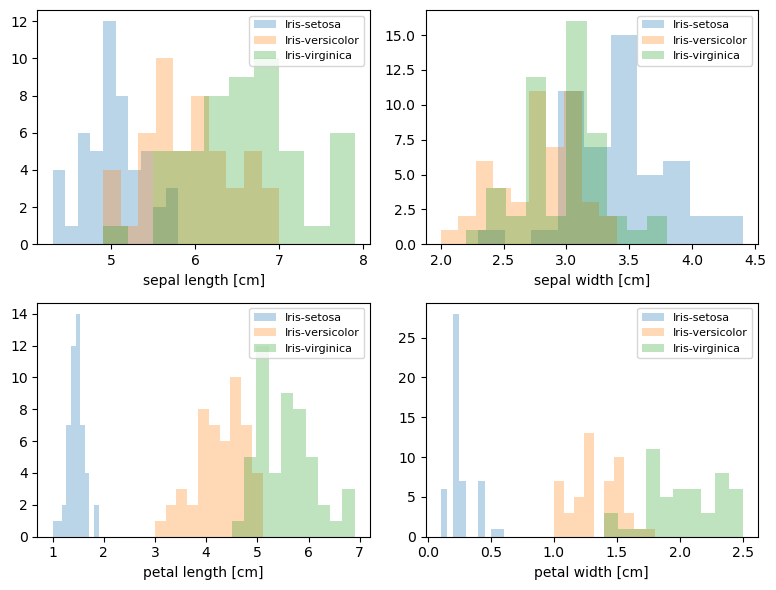

In [42]:
labels = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]

features = {
    0: "sepal length [cm]",
    1: "sepal width [cm]",
    2: "petal length [cm]",
    3: "petal width [cm]",
}

plt.figure(figsize=(8, 6))
for cnt in features.keys():
    plt.subplot(2, 2, cnt + 1)
    for label in labels:
        plt.hist(
            x=X[y == label, cnt],
            label=label,
            bins=10,
            alpha=0.3,
        )
    plt.xlabel(xlabel=features[cnt])
    plt.legend(loc="upper right", fancybox=True, fontsize=8)
plt.tight_layout()
plt.show()

# PCA step by step

1. **Standardizing**: standardize the data (zero mean, unit variance)
2. **Eigendecomposition**: obtain the eigenvectors and eigenvalues from the covariance matrix or perform singular value decomposition of the data matrix
3. **Selection of principal components**: sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace.
4. **Construction of the projection matrix**: construct the projection matrix from the selected $k$ eigenvectors.
5. **Transformation into new feature subspace**: transform the original data using the projection matrix to a $k$-dimensional feature subspace.

## 1. Standardizing

Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features.
Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.
Although all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data by removing the mean and scaling to unit variance:

In [43]:
X_std = StandardScaler().fit_transform(X=X)

## 2. Eigendecomposition

The eigenvectors and eigenvalues of a covariance matrix represent the "core" of a PCA: the eigenvectors (principal components) determine the directions of the new feature subspace, and the eigenvalues determine their magnitude.
In other words, the eigenvalues explain the variance of the data along the new feature axes.

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, where each element represents the covariance between two features.
The covariance between two features is calculated as follows.
Here we assume that the data already has a mean of zero.

$$
\text{cov}({x_1,x_2}) =
\mathbb{E}_{\text{x}_1\sim{}P_{\text{x}_1},\text{x}_2\sim{}P_{\text{x}_2}}
[x_1\cdot x_2]
$$

High absolute values of the covariance mean that the values change a lot and at the same time are far from their mean values.
If the sign of the covariance is positive, both random variables tend to take on relatively high values simultaneously.
If the sign of the covariance is negative, then one random variable tends to take on a relatively high value at the times that the other takes on a relatively low value and vice versa.

If the random variable pair $(\text{x}_1,\text{x}_2)$ can take on the values $\left( x^{(i)}_1,x^{(i)}_2 \right)$ for $i=1,\dots m$ with equal probabilities $p_i = \frac{1}{m}$, then the covariance can be written as:

$$
\text{cov}({x_1,x_2}) =
\frac{1}{m} \sum_{i} x^{(i)}_1 x^{(i)}_2
$$

We can summarize the calculation of the covariance matrix $\mathbf{\Sigma}$ via the following matrix equation.
Note that we apply Bessel's correction (the use of $m-1$ instead of $m$ in the formula), which corrects the bias in the estimation of the population variance using the sample variance.

$$
\Sigma = \frac{1}{m-1} \mathbf{X}^T \mathbf{X}
$$

We can compute the covariance matrix by hand:

In [44]:
S = (X_std).T.dot((X_std)) / (X_std.shape[0] - 1)
print(f"Covariance matrix:{os.linesep}{S}")

Covariance matrix:
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Or by using NumPy's [`cov()`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) function:

In [45]:
print(f"Covariance matrix (NumPy):{os.linesep}{np.cov(m=X_std.T)}")

Covariance matrix (NumPy):
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Next, we perform an eigendecomposition on the covariance matrix:

In [46]:
eigenvalues, eigenvectors = np.linalg.eig(a=S)

print(f"Eigenvectors:{os.linesep}{eigenvectors}")
print(f"Eigenvalues:{os.linesep}{eigenvalues}")

Eigenvectors:
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
Eigenvalues:
[2.93035378 0.92740362 0.14834223 0.02074601]


> While the eigendecomposition of the covariance matrix may be more intuitive, most PCA implementations perform a singular value decomposition (SVD) of the *data matrix* (see lecture slides for why this is equivalent) to improve the computational efficiency.

## 3. Selection of principal components

In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional feature subspace, we need to inspect the corresponding eigenvalues.
The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [47]:
# Make a list of (eigenvalue, eigenvector) tuples
eigenpairs = [
    (np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))
]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigenpairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print("Eigenvalues in descending order:")
for i in eigenpairs:
    print(i[0])

Eigenvalues in descending order:
2.930353775589318
0.9274036215173411
0.14834222648163967
0.020746013995596172


After sorting the eigenpairs, the next question is: "How many principal components are we going to choose for our new feature subspace?"
A useful measure is the so-called "explained variance", which can be calculated from the eigenvalues.
The explained variance tells us how much "information" can be attributed to each of the principal components.

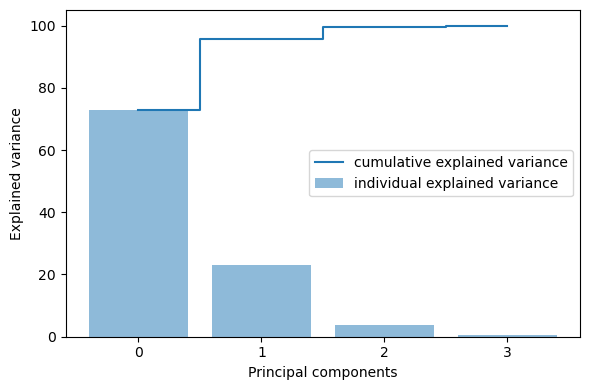

In [48]:
individual_explained_variance = [
    (i / sum(eigenvalues)) * 100 for i in sorted(eigenvalues, reverse=True)
]
cumulative_explained_variance = np.cumsum(a=individual_explained_variance)

plt.figure(figsize=(6, 4))
plt.bar(
    x=range(len(eigenvalues)),
    height=individual_explained_variance,
    alpha=0.5,
    align="center",
    label="individual explained variance",
)
plt.step(
    x=range(len(eigenvalues)),
    y=cumulative_explained_variance,
    where="mid",
    label="cumulative explained variance",
)
plt.xlabel("Principal components")
plt.ylabel("Explained variance")
plt.xticks(ticks=range(len(eigenvalues)), labels=range(len(eigenvalues)))
plt.legend(loc="best")
plt.tight_layout()
plt.show()

The plot above clearly shows that most of the variance (72.77%) can be explained by the first principal component alone.
The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information.
Together, the first two principal components contain 95.8% of the information.

## 4. Construction of the projection matrix

Next, we construct the projection matrix that will be used to transform the data onto the new feature subspace.
The projection matrix is basically just a matrix of our concatenated top $k$ eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues.

In [49]:
W = np.hstack((eigenpairs[0][1].reshape(4, 1), eigenpairs[1][1].reshape(4, 1)))
print(f"W:{os.linesep}{W}")

W:
[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 5. Transformation into new feature subspace

In this last step we will use the projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation $\textbf{Z} = \textbf{X}\textbf{W}$, where $\textbf{Z}$ is a $150 \times 2$ matrix of our transformed samples.

In [50]:
Z = X_std.dot(W)

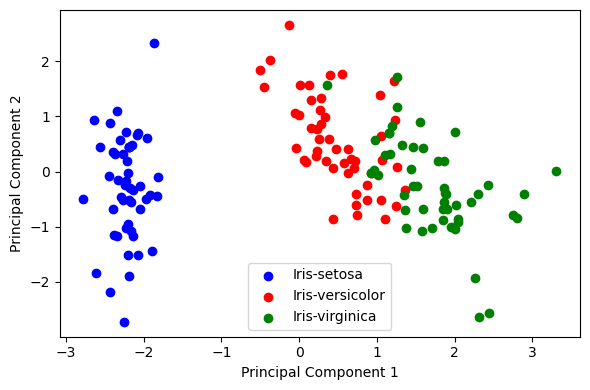

In [51]:
plt.figure(figsize=(6, 4))
for label, color in zip(
    ("Iris-setosa", "Iris-versicolor", "Iris-virginica"), ("blue", "red", "green")
):
    plt.scatter(Z[y == label, 0], Z[y == label, 1], label=label, c=color)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()